# Starting Points

## Imports

In [1]:
import pandas as pd
from cobra import flux_analysis
from cobra.io import read_sbml_model, write_sbml_model
from model_functions import *
import seaborn as sns
import matplotlib.pyplot as plt
import math

## Reading the Models

In [2]:
"""
Read and prepare c3 model
"""

c3_model = read_sbml_model("c3_model.xml")

c3_model.solver = "glpk"

c3_model.objective = "Arabidopsis_biomass_tx"

#Setting up Rubisco carboxylase/oxygenase ratio in C3 model
set_fixed_flux_ratio({'RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p':3,'RXN_961_p':1},c3_model)

#Setting up Light dependent maintenace in the C3 model
def c3_maintenance(c3_model):
    c3_model.reactions.ATPase_tx.flux_expression
    c3_model.reactions.Photon_tx.flux_expression

    const = c3_model.problem.Constraint((0.0049 * c3_model.reactions.Photon_tx.flux_expression + 2.7852) - 
                                        c3_model.reactions.ATPase_tx.flux_expression , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

    const = c3_model.problem.Constraint(c3_model.reactions.ATPase_tx.flux_expression - 
                                        3 *(c3_model.reactions.NADPHoxc_tx.flux_expression + c3_model.reactions.NADPHoxp_tx.flux_expression + 
                                            c3_model.reactions.NADPHoxm_tx.flux_expression) , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

c3_maintenance(c3_model)

In [3]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("c4_model.xml")

c4_model.solver = "glpk"

c4_model.objective = '[B]_Maize_biomass_tx'


def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - 
                                          atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  
                                        3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + 
                                             c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + 
                                             c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression - 
                                        3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + 
                                             c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + 
                                             c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)

No objective coefficients in model. Unclear what should be optimized


## Simulating with pFBA

In this analysis the functions below will receive a light and nitrogen flux values. It will then set this values as the upper bounds of the corresponding uptake reactions, while leaving the lower bounds at zero. Finaly, it will perform a pFBA with these constrains and extract the sum of fluxes and growth (biomass reaction flux value). As a result, the models are free to uptake as much flux as possible of either light or nitrogen, and in every scenario the maximum uptake of one will restrain the uptake of the other a.k.a one will be a limiting factor. This relationship can be observed in the plots below.

### Starting points

Through analysis of ther literature, **9 starting points** were defined, corresponding to a range of Light and Nitrogen uptakes who will serve as scenarios in which we will evaluate the model's metabolic plasticity, as constrained by the absolute sum of fluxes and their ability to yield close-to-optimum biomass flux solutions.
The stating points correspond to a combination of **3 Light conditions (100, 250, 500)** and **3 Nitrogen conditions (0.2, 2.5, 6)**

### Defining Light limiting and Nitrogen Limiting Starting Points

In [4]:
"""
Functions to perform the simulations for evaluation of nitrogen or light limiting conditions
"""

def c3_simulation(light, N, c3_model):
    with c3_model:
        c3_model.objective = "Arabidopsis_biomass_tx"
        #Bounds for light
        set_bounds('Photon_tx', (0, light), c3_model)
        #Bounds for Nitrogen
        set_bounds('Nitrate_tx', (0, N), c3_model)
        #pFBA
        c3_model.objective = "Arabidopsis_biomass_tx"
        solution = flux_analysis.pfba(c3_model)
        solution_frame=solution.to_frame()
        N_uptake = solution_frame.loc["Nitrate_tx"]["fluxes"]
        Light_uptake = solution_frame.loc["Photon_tx"]["fluxes"]
        return (Light_uptake, N_uptake)

def c4_simulation(light, N, c4_model):
    ##C4
    with c4_model:
        c4_model.objective = '[B]_Maize_biomass_tx'
        #Light Uptale constrain
        B_Im_hnu = c4_model.reactions.get_by_id("[B]_Photon_tx")
        M_Im_hnu = c4_model.reactions.get_by_id("[M]_Photon_tx")
        #CONSTRAINT: Total Photon uptake limited to "light" µE
        const_hnu_sum = c4_model.problem.Constraint( B_Im_hnu.flux_expression + M_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_sum)
        #CONSTRAINT: Total Photon uptake by bundle sheath must be less or equal than in mesophyll
        const_hnu_ratio = c4_model.problem.Constraint( M_Im_hnu.flux_expression - B_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_ratio)
        #CONSTRAINT : Total N uptake must not surpass defined upper bound
        bs_n = c4_model.reactions.get_by_id("[B]_Nitrate_tx")
        m_n = c4_model.reactions.get_by_id("[M]_Nitrate_tx")
        const_n_ratio = c4_model.problem.Constraint( bs_n.flux_expression + m_n.flux_expression,
                                               lb = 0, ub = N)
        c4_model.add_cons_vars(const_n_ratio)
        #pFBA
        solution = flux_analysis.pfba(c4_model)
        solution_frame=solution.to_frame()
        N_uptake = solution_frame.loc["[B]_Nitrate_tx"]["fluxes"] + solution_frame.loc["[M]_Nitrate_tx"]["fluxes"]
        Light_uptake = solution_frame.loc["[B]_Photon_tx"]["fluxes"] + solution_frame.loc["[M]_Photon_tx"]["fluxes"]
        return (Light_uptake, N_uptake)

In [5]:
"""
Build Dictionary with the combination of Light/Nitrogen conditions as keys and nitrogen and light effective uptake as values
"""

#Grid of light and Nitrogen conditions to use
light_uptake = [100, 250, 500]
nitrogen_uptake = [0.2, 2.5, 6]

#Dictionaries to hold the results
res_c3 = {}
res_c4 = {}

#Perform the simulations for diferent combinations of Light/N and store them in the dictionary
for l in light_uptake:
    for n in nitrogen_uptake:
        res_c3[(l,n)] = c3_simulation(l,n,c3_model)
        res_c4[(l,n)] = c4_simulation(l,n,c4_model)


In [6]:
"""
Dictionary with C3 model light and nitrogen effective uptakes for every starting point
"""

print(res_c3)

{(100, 0.2): (23.59906736369348, 0.2000000000000115), (100, 2.5): (100.0, 1.0650421459213952), (100, 6): (100.0, 1.0650421459213952), (250, 0.2): (23.599067363691972, 0.1999999999999946), (250, 2.5): (227.66303654238237, 2.4999999999999627), (250, 6): (249.99999999996513, 2.751071900041086), (500, 0.2): (23.599067363691972, 0.1999999999999946), (500, 2.5): (227.66303654238237, 2.4999999999999627), (500, 6): (499.999999999922, 5.561121490240462)}


In [7]:
"""
Dictionary with C4 model light and nitrogen effective uptakes for every starting point
"""
print(res_c4)

{(100, 0.2): (45.080637691816, 0.20000000000000123), (100, 2.5): (100.0, 0.51826412018872), (100, 6): (100.0, 0.51826412018872), (250, 0.2): (45.08063769181526, 0.1999999999999958), (250, 2.5): (250.0, 1.3835780512366291), (250, 6): (250.0, 1.3835780512366291), (500, 0.2): (45.08063769181526, 0.1999999999999958), (500, 2.5): (448.535180267036, 2.4999999999998535), (500, 6): (500.0, 2.825767936316318)}


In [8]:
"""Classification of Starting points"""

def classif(res_classif, res):
    for start in res.keys():
        if math.isclose(start[0], res[start][0], rel_tol=0.01):
            res_classif[start] = "Light Limiting Condition"
        else:
            res_classif[start] = "Nitrogen Limiting Condition"
            
classif_c3 = {}
classif_c4 = {}

classif(classif_c3, res_c3)
classif(classif_c4, res_c4)

In [9]:
"""Creating dataframe to display the results"""
Uptake = [str(tuple) for tuple in classif_c3.keys()]
Evaluation_c3 = [string for string in classif_c3.values()]
Evaluation_c4 = [string for string in classif_c4.values()]
list_of_tuples = list(zip(Uptake, Evaluation_c3, Evaluation_c4))
df_classif = pd.DataFrame(list_of_tuples, columns=["Uptake", "Evaluation_c3", "Evaluation_c4"])

df_classif


,Uptake,Evaluation_c3,Evaluation_c4
0,"(100, 0.2)",Nitrogen Limiting Condition,Nitrogen Limiting Condition
1,"(100, 2.5)",Light Limiting Condition,Light Limiting Condition
2,"(100, 6)",Light Limiting Condition,Light Limiting Condition
3,"(250, 0.2)",Nitrogen Limiting Condition,Nitrogen Limiting Condition
4,"(250, 2.5)",Nitrogen Limiting Condition,Light Limiting Condition
5,"(250, 6)",Light Limiting Condition,Light Limiting Condition
6,"(500, 0.2)",Nitrogen Limiting Condition,Nitrogen Limiting Condition
7,"(500, 2.5)",Nitrogen Limiting Condition,Nitrogen Limiting Condition
8,"(500, 6)",Light Limiting Condition,Light Limiting Condition


### Determining optimal biomass and absolute sum of fluxes for starting points

In [10]:
"""
Functions to perform the simulationm for determination of optimal biomass and absolute sum of fluxes
"""

def c3_simulation(light, N, c3_model):
    with c3_model:
        c3_model.objective = "Arabidopsis_biomass_tx"
        #Bounds for light
        set_bounds('Photon_tx', (0, light), c3_model)
        #Bounds for Nitrogen
        set_bounds('Nitrate_tx', (0, N), c3_model)
        #pFBA
        c3_model.objective = "Arabidopsis_biomass_tx"
        solution = flux_analysis.pfba(c3_model)
        sum_of_flux = solution.fluxes.abs().sum()
        solution_frame=solution.to_frame()
        growth = solution_frame.loc["Arabidopsis_biomass_tx"]["fluxes"]
        return (sum_of_flux, growth)

def c4_simulation(light, N, c4_model):
    ##C4
    with c4_model:
        c4_model.objective = '[B]_Maize_biomass_tx'
        #Light Uptale constrain
        B_Im_hnu = c4_model.reactions.get_by_id("[B]_Photon_tx")
        M_Im_hnu = c4_model.reactions.get_by_id("[M]_Photon_tx")
        #CONSTRAINT: Total Photon uptake limited to "light" µE
        const_hnu_sum = c4_model.problem.Constraint( B_Im_hnu.flux_expression + M_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_sum)
        #CONSTRAINT: Total Photon uptake by bundle sheath must be less or equal than in mesophyll
        const_hnu_ratio = c4_model.problem.Constraint( M_Im_hnu.flux_expression - B_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_ratio)
        #CONSTRAINT : Total N uptake must not surpass defined upper bound
        bs_n = c4_model.reactions.get_by_id("[B]_Nitrate_tx")
        m_n = c4_model.reactions.get_by_id("[M]_Nitrate_tx")
        const_n_ratio = c4_model.problem.Constraint( bs_n.flux_expression + m_n.flux_expression,
                                               lb = 0, ub = N)
        c4_model.add_cons_vars(const_n_ratio)
        #pFBA
        solution = flux_analysis.pfba(c4_model)
        sum_of_flux = solution.fluxes.abs().sum()
        solution_frame=solution.to_frame()
        growth = solution_frame.loc["[B]_Maize_biomass_tx"]["fluxes"]
        return (sum_of_flux, growth)

In [11]:
"""
Build Dictionary with the combination of Light/Nitrogen conditions as a key,
 and Biomass flux and Sum of fluxes as values
"""

#Grid of light and Nitrogen conditions to use
light_uptake = [100, 250, 500]
nitrogen_uptake = [0.2, 2.5, 6]

#Dictionaries to hold the results
res_c3 = {}
res_c4 = {}

#Perform the simulations for diferent combinations of Light/N and store them in the dictionary
for l in light_uptake:
    for n in nitrogen_uptake:
        res_c3[(l,n)] = c3_simulation(l,n,c3_model)
        res_c4[(l,n)] = c4_simulation(l,n,c4_model)


In [12]:
"""
Dictionary with C3 model starting points as keys and Sum of fluxes and biomass flux as values
"""

print(res_c3)

{(100, 0.2): (144.10493789253246, 0.002131443319473939), (100, 2.5): (591.7936402449626, 0.01135038483441206), (100, 6): (591.7936402449626, 0.01135038483441206), (250, 0.2): (144.10493789253246, 0.002131443319473939), (250, 2.5): (1336.7397177187227, 0.026643041493424287), (250, 6): (1467.1946503805327, 0.029318769113676486), (500, 0.2): (144.10493789253246, 0.002131443319473939), (500, 2.5): (1336.7397177187227, 0.026643041493424287), (500, 6): (2929.3002339386258, 0.05926607624578246)}


In [13]:
"""
Dictionary with C4 model starting points as keys and Sum of fluxes and biomass flux as values
"""
print(res_c4)

{(100, 0.2): (307.44209419815803, 0.003956163833772735), (100, 2.5): (693.4916382202775, 0.0102516888431631), (100, 6): (693.4916382202775, 0.0102516888431631), (250, 0.2): (307.44209419815803, 0.003956163833772735), (250, 2.5): (1749.067597877077, 0.027368307237520234), (250, 6): (1749.067597877077, 0.027368307237520234), (500, 0.2): (307.44209419815803, 0.003956163833772735), (500, 2.5): (3012.6684876814793, 0.049452047922157794), (500, 6): (3509.8041135046087, 0.05589600456144882)}


In [14]:
"""
Build a pandas dataframe from the dictionaries
"""

def frame_from_dict(res):
    Uptake = [str(tuple) for tuple in res.keys()]
    Biomass = [tuple[1] for tuple in res.values()]
    Sum_of_fluxes = [tuple[0] for tuple in res.values()]
    list_of_tuples = list(zip(Uptake, Biomass, Sum_of_fluxes))
    df = pd.DataFrame(list_of_tuples, columns=["Uptake", "Biomass", "Sum_of_fluxes"])
    return df

df_c4 = frame_from_dict(res_c4)
df_c3 = frame_from_dict(res_c3)


### Plots

In the following plots, a comparative analysis between the biomass flux and the sum of fluxes between the C3 and C4 models is performed for every starting point. The previous information about nitrogen and light limitation is incorporated using a color scheme. The **nitrogen-limited** starting points are represented in **green**, while the **light-limited** points are represented in **yellow**. In **grey** is represented the starting point which is **nitrogen-limited in C3** and **light-limited in C4**.

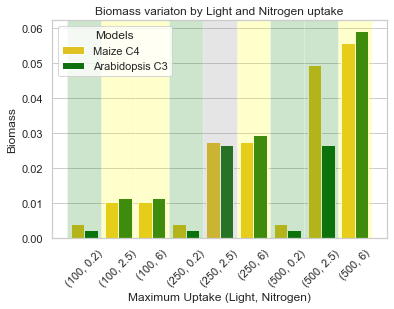

In [15]:
"""
Plot biomass flux values as a function of the Light/N uptake
"""

concatenated = pd.concat([df_c4.assign(Models ='Maize C4'), df_c3.assign(Models ='Arabidopsis C3')])
sns.set_theme(style="whitegrid")
sns.barplot(x='Uptake', y='Biomass', data=concatenated, hue="Models", palette=["gold", "green"])
plt.title("Biomass variaton by Light and Nitrogen uptake")
plt.xlabel('Maximum Uptake (Light, Nitrogen)')
plt.ylabel('Biomass')
plt.xticks(rotation=45, horizontalalignment='center', fontweight='light')
plt.axvspan(xmin = -0.5,xmax= 0.5, ymin = 0, ymax = 1, facecolor = "green",  alpha = 0.2)
plt.axvspan(xmin = 0.5,xmax= 1.5, ymin = 0, ymax = 1, facecolor = "yellow",  alpha = 0.2)
plt.axvspan(xmin = 1.5,xmax= 2.5, ymin = 0, ymax = 1, facecolor = "yellow",  alpha = 0.2)
plt.axvspan(xmin = 2.5,xmax= 3.5, ymin = 0, ymax = 1, facecolor = "green",  alpha = 0.2)
plt.axvspan(xmin = 3.5,xmax= 4.5, ymin = 0, ymax = 1, facecolor = "grey",  alpha = 0.2)
plt.axvspan(xmin = 4.5,xmax= 5.5, ymin = 0, ymax = 1, facecolor = "yellow",  alpha = 0.2)
plt.axvspan(xmin = 5.5,xmax= 6.5, ymin = 0, ymax = 1, facecolor = "green",  alpha = 0.2)
plt.axvspan(xmin = 6.5,xmax= 7.5, ymin = 0, ymax = 1, facecolor = "green",  alpha = 0.2)
plt.axvspan(xmin = 7.5,xmax= 8.5, ymin = 0, ymax = 1, facecolor = "yellow",  alpha = 0.2)

#plt.savefig('Biomass_Points.svg', format='svg', bbox_inches = 'tight')
plt.show()

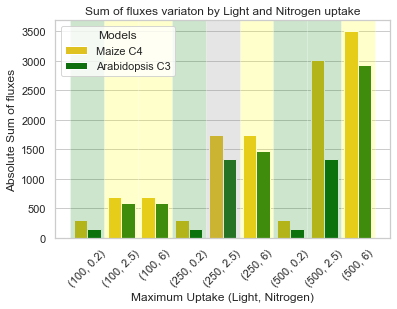

In [16]:
#Plot Sum of fluxes as a function of the Light/N uptake

sns.barplot(x='Uptake', y='Sum_of_fluxes', data=concatenated, hue="Models", palette=["gold", "green"])
plt.title("Sum of fluxes variaton by Light and Nitrogen uptake")
plt.xlabel('Maximum Uptake (Light, Nitrogen)')
plt.ylabel('Absolute Sum of fluxes')
plt.xticks(rotation=45, horizontalalignment='center', fontweight='light')
plt.axvspan(xmin = -0.5,xmax= 0.5, ymin = 0, ymax = 1, facecolor = "green",  alpha = 0.2)
plt.axvspan(xmin = 0.5,xmax= 1.5, ymin = 0, ymax = 1, facecolor = "yellow",  alpha = 0.2)
plt.axvspan(xmin = 1.5,xmax= 2.5, ymin = 0, ymax = 1, facecolor = "yellow",  alpha = 0.2)
plt.axvspan(xmin = 2.5,xmax= 3.5, ymin = 0, ymax = 1, facecolor = "green",  alpha = 0.2)
plt.axvspan(xmin = 3.5,xmax= 4.5, ymin = 0, ymax = 1, facecolor = "grey",  alpha = 0.2)
plt.axvspan(xmin = 4.5,xmax= 5.5, ymin = 0, ymax = 1, facecolor = "yellow",  alpha = 0.2)
plt.axvspan(xmin = 5.5,xmax= 6.5, ymin = 0, ymax = 1, facecolor = "green",  alpha = 0.2)
plt.axvspan(xmin = 6.5,xmax= 7.5, ymin = 0, ymax = 1, facecolor = "green",  alpha = 0.2)
plt.axvspan(xmin = 7.5,xmax= 8.5, ymin = 0, ymax = 1, facecolor = "yellow",  alpha = 0.2)
#plt.savefig('SoF_Points.svg', format='svg', bbox_inches = 'tight')
plt.show()